# Home Credit Default Risk
## Data
The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task.


## Import Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
import warnings
import math
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/application-datasets/application_train.csv
/kaggle/input/application-datasets/HomeCredit_columns_description.csv
/kaggle/input/application-datasets/application_test.csv


In [3]:
warnings.simplefilter(action='ignore', category=Warning)

# Read Dataset

In [4]:
path = '/kaggle/input/application-datasets/application_train.csv'
df_train = pd.read_csv(path)

In [5]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [7]:
check_df(df_train)

##################### Shape #####################
(307511, 122)
##################### Types #####################
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object
##################### Head #####################
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans       

# Split DataSet

Split the dataset into three types: categorical, numerical, and cardinal. This separation will assist us in analyzing each type individually. Please provide the names of the categorical variables, numerical variables, and those that are categorical but have a numeric appearance in the dataset. > 

*Note that categorical variables that appear numeric should also be included in the categorical group.*

In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
       veri setindeki kategorik, numeric ve kategorik fakat kardinal değişkenlerin isimlerini verir.
       Not: kategorik değikenlerin içersine numerik görünümlü ketagorik değişkenler de dahildir.

       Args:
           dataframe: dataframe
               değişken isimleri alınmak istenen dataframe'dir,
           cat_th: int, float
               numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
           car_th: int, float
               kategorik fakat kardinal değişkenler için sınıf eşik değeri.

       Returns:
           cat_cols: list
               kategorik değişken listesi
           num_cols: list
               numerik değişken listesi
           cat_but_car: list
               kategorik görünümlü kardinal değişken listesi

       Notes:
           cat_cols + num_cols + cat_but_car = toplam değişken sayısı
           num_but_cat cat_cols'un içerisinde.

       """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                                                       dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                                                       dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    #Number Columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    num_cols = [col for col in num_cols if dataframe[col].nunique() != len(dataframe)]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


In [9]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 66
cat_but_car: 1
num_but_cat: 39


### Exmine Numeric Features

In [10]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(f"**********  {numerical_col} **********")
    print(dataframe[numerical_col].describe(quantiles).T)
    print("**********************************************")

    if plot:
        dataframe[numerical_col].hist()
        plt.title(numerical_col)
        plt.xlabel(numerical_col)
        plt.show(block=True)


In [11]:
for col in num_cols:
    num_summary(df_train, col)

**********  CNT_CHILDREN **********
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           0.000000
70%           0.000000
80%           1.000000
90%           2.000000
95%           2.000000
99%           3.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
**********************************************
**********  AMT_INCOME_TOTAL **********
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
5%       6.750000e+04
10%      8.100000e+04
20%      9.900000e+04
30%      1.125000e+05
40%      1.350000e+05
50%      1.471500e+05
60%      1.620000e+05
70%      1.800000e+05
80%      2.250000e+05
90%      2.700000e+05
95%      3.375000e+05
99%      4.725000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
**************************************

# Outlier

### Exmine Outlier

In [12]:
def outlier_threshold(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return up_limit, low_limit


In [13]:
def check_outliers(dataframe, col_name, q1= 0.25, q3=0.75):
    up_limit, low_limit = outlier_threshold(dataframe, col_name, q1, q3)
    return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any(axis=None)


In [14]:
box_list = []
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))
    if check_outliers(df_train, col):
        box_list.append(col)

CNT_CHILDREN   True
AMT_INCOME_TOTAL   True
AMT_CREDIT   True
AMT_ANNUITY   True
AMT_GOODS_PRICE   True
REGION_POPULATION_RELATIVE   True
DAYS_BIRTH   False
DAYS_EMPLOYED   True
DAYS_REGISTRATION   True
DAYS_ID_PUBLISH   False
OWN_CAR_AGE   True
CNT_FAM_MEMBERS   True
HOUR_APPR_PROCESS_START   True
EXT_SOURCE_1   False
EXT_SOURCE_2   False
EXT_SOURCE_3   False
APARTMENTS_AVG   True
BASEMENTAREA_AVG   True
YEARS_BEGINEXPLUATATION_AVG   True
YEARS_BUILD_AVG   True
COMMONAREA_AVG   True
ELEVATORS_AVG   True
ENTRANCES_AVG   True
FLOORSMAX_AVG   True
FLOORSMIN_AVG   True
LANDAREA_AVG   True
LIVINGAPARTMENTS_AVG   True
LIVINGAREA_AVG   True
NONLIVINGAPARTMENTS_AVG   True
NONLIVINGAREA_AVG   True
APARTMENTS_MODE   True
BASEMENTAREA_MODE   True
YEARS_BEGINEXPLUATATION_MODE   True
YEARS_BUILD_MODE   True
COMMONAREA_MODE   True
ELEVATORS_MODE   True
ENTRANCES_MODE   True
FLOORSMAX_MODE   True
FLOORSMIN_MODE   True
LANDAREA_MODE   True
LIVINGAPARTMENTS_MODE   True
LIVINGAREA_MODE   True
NONLIVING

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(1, 0, 'HOUR_APPR_PROCESS_START'),
  Text(2, 0, 'APARTMENTS_AVG'),
  Text(3, 0, 'BASEMENTAREA_AVG'),
  Text(4, 0, 'YEARS_BEGINEXPLUATATION_AVG'),
  Text(5, 0, 'YEARS_BUILD_AVG'),
  Text(6, 0, 'COMMONAREA_AVG'),
  Text(7, 0, 'ELEVATORS_AVG'),
  Text(8, 0, 'ENTRANCES_AVG'),
  Text(9, 0, 'FLOORSMAX_AVG'),
  Text(10, 0, 'FLOORSMIN_AVG')])

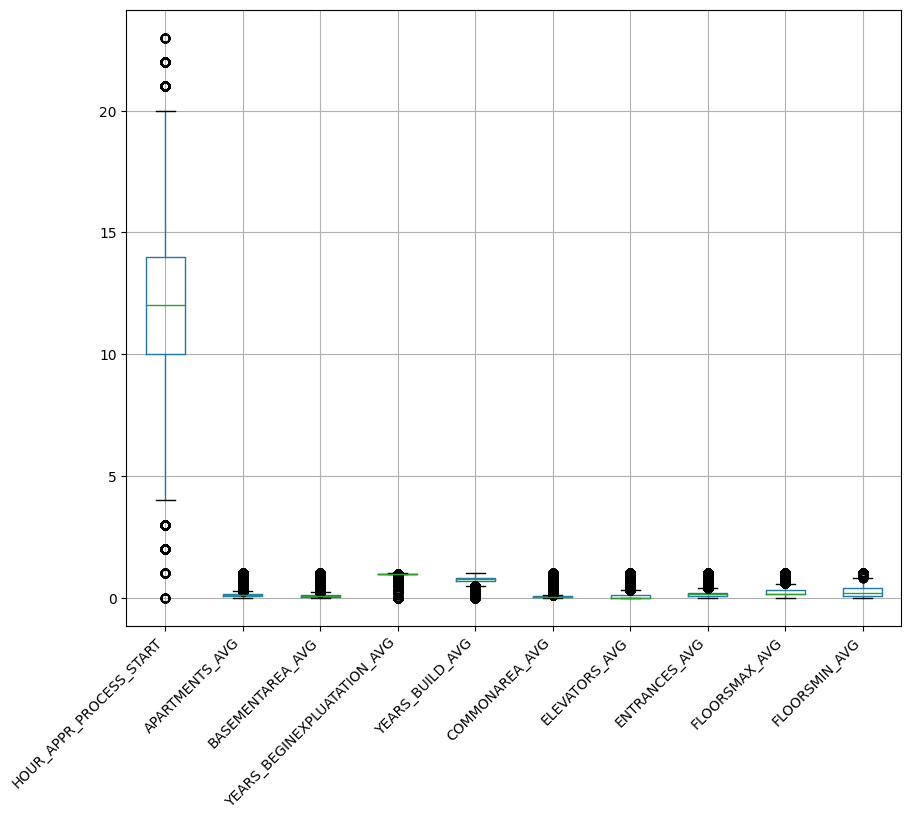

In [15]:
plt.figure(figsize=(10, 8))
df_train.boxplot(column=box_list[10:20])
plt.xticks(rotation=45, ha='right')

In [16]:
def grab_outliers(dataframe, col_name, index=False):
    up_limit, low_limit = outlier_threshold(dataframe, col_name)

    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].shape[0] > 10:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].head())
    else:
        print(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)])

    if index:
        outliers_index = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].index
        return outliers_index


In [17]:
for col in num_cols:
    outliers_index =  grab_outliers(df_train, col, index=True)

     SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
91       100108       0         Cash loans           F            N   
92       100110       0         Cash loans           M            Y   
144      100166       0         Cash loans           F            N   
180      100209       1    Revolving loans           M            N   
182      100211       0         Cash loans           M            N   

    FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
91                Y             3          171000.0    545040.0      31288.5   
92                Y             3          135000.0    373140.0      25065.0   
144               Y             3           58500.0    152820.0      15241.5   
180               Y             3          180000.0    540000.0      27000.0   
182               N             3          225000.0    746280.0      49873.5   

     ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
91   ...   

In [18]:
df_train.iloc[outliers_index].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
65,100077,0,Cash loans,M,N,Y,0,180000.0,1256400.0,40657.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
105,100124,0,Cash loans,M,N,Y,0,225000.0,448272.0,28647.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,8.0
200,100233,0,Cash loans,F,N,Y,0,216000.0,679671.0,28926.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
284,100327,0,Cash loans,M,Y,Y,0,180000.0,407727.0,32341.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,9.0
334,100383,0,Cash loans,M,Y,N,2,180000.0,640080.0,20929.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,9.0


In [19]:
def replace_with_thresholds(dataframe, variable):
    up_limit, low_limit = outlier_threshold(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [20]:
for col in num_cols:
    replace_with_thresholds(df_train, col)

In [21]:
for col in num_cols:
    print(col, " ", check_outliers(df_train, col))

CNT_CHILDREN   False
AMT_INCOME_TOTAL   False
AMT_CREDIT   False
AMT_ANNUITY   False
AMT_GOODS_PRICE   False
REGION_POPULATION_RELATIVE   False
DAYS_BIRTH   False
DAYS_EMPLOYED   False
DAYS_REGISTRATION   False
DAYS_ID_PUBLISH   False
OWN_CAR_AGE   False
CNT_FAM_MEMBERS   False
HOUR_APPR_PROCESS_START   False
EXT_SOURCE_1   False
EXT_SOURCE_2   False
EXT_SOURCE_3   False
APARTMENTS_AVG   False
BASEMENTAREA_AVG   False
YEARS_BEGINEXPLUATATION_AVG   False
YEARS_BUILD_AVG   False
COMMONAREA_AVG   False
ELEVATORS_AVG   False
ENTRANCES_AVG   False
FLOORSMAX_AVG   False
FLOORSMIN_AVG   False
LANDAREA_AVG   False
LIVINGAPARTMENTS_AVG   False
LIVINGAREA_AVG   False
NONLIVINGAPARTMENTS_AVG   False
NONLIVINGAREA_AVG   False
APARTMENTS_MODE   False
BASEMENTAREA_MODE   False
YEARS_BEGINEXPLUATATION_MODE   False
YEARS_BUILD_MODE   False
COMMONAREA_MODE   False
ELEVATORS_MODE   False
ENTRANCES_MODE   False
FLOORSMAX_MODE   False
FLOORSMIN_MODE   False
LANDAREA_MODE   False
LIVINGAPARTMENTS_MODE   Fa

### Examine Missing Values

#### Advanced Missin Value Anlysis

In [22]:
import missingno as msno

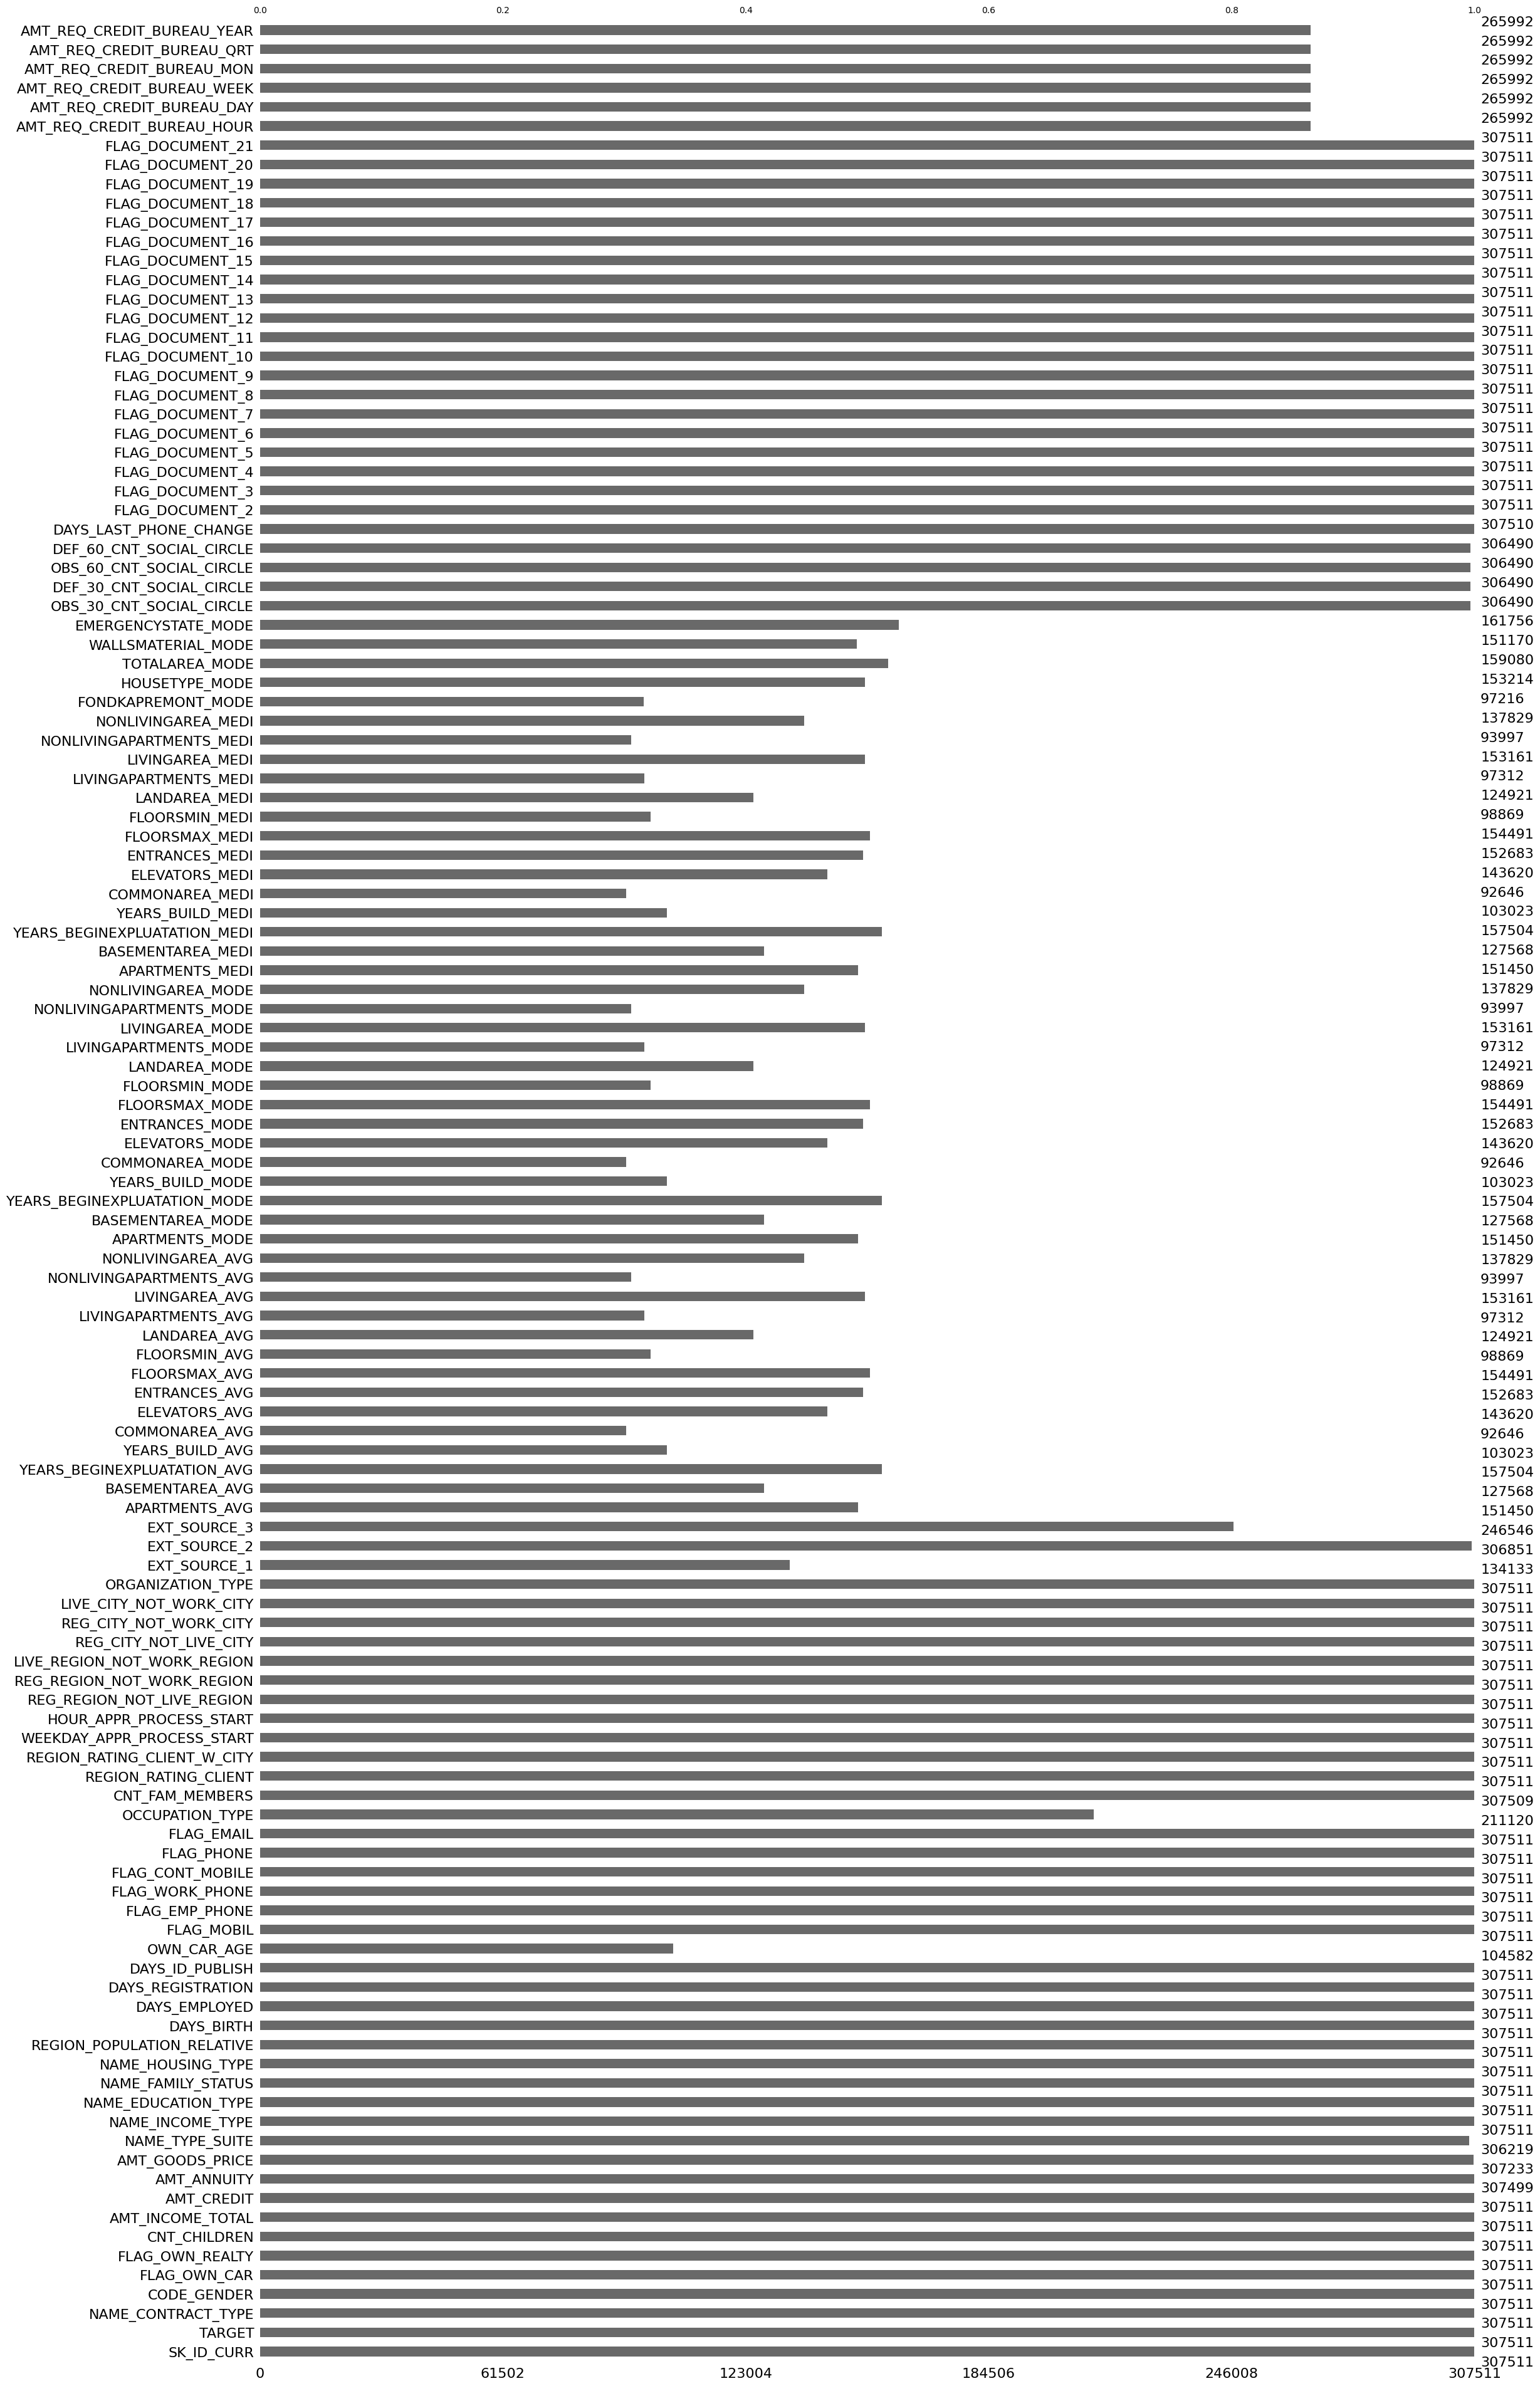

In [23]:
msno.bar(df_train)
plt.show()

<Axes: >

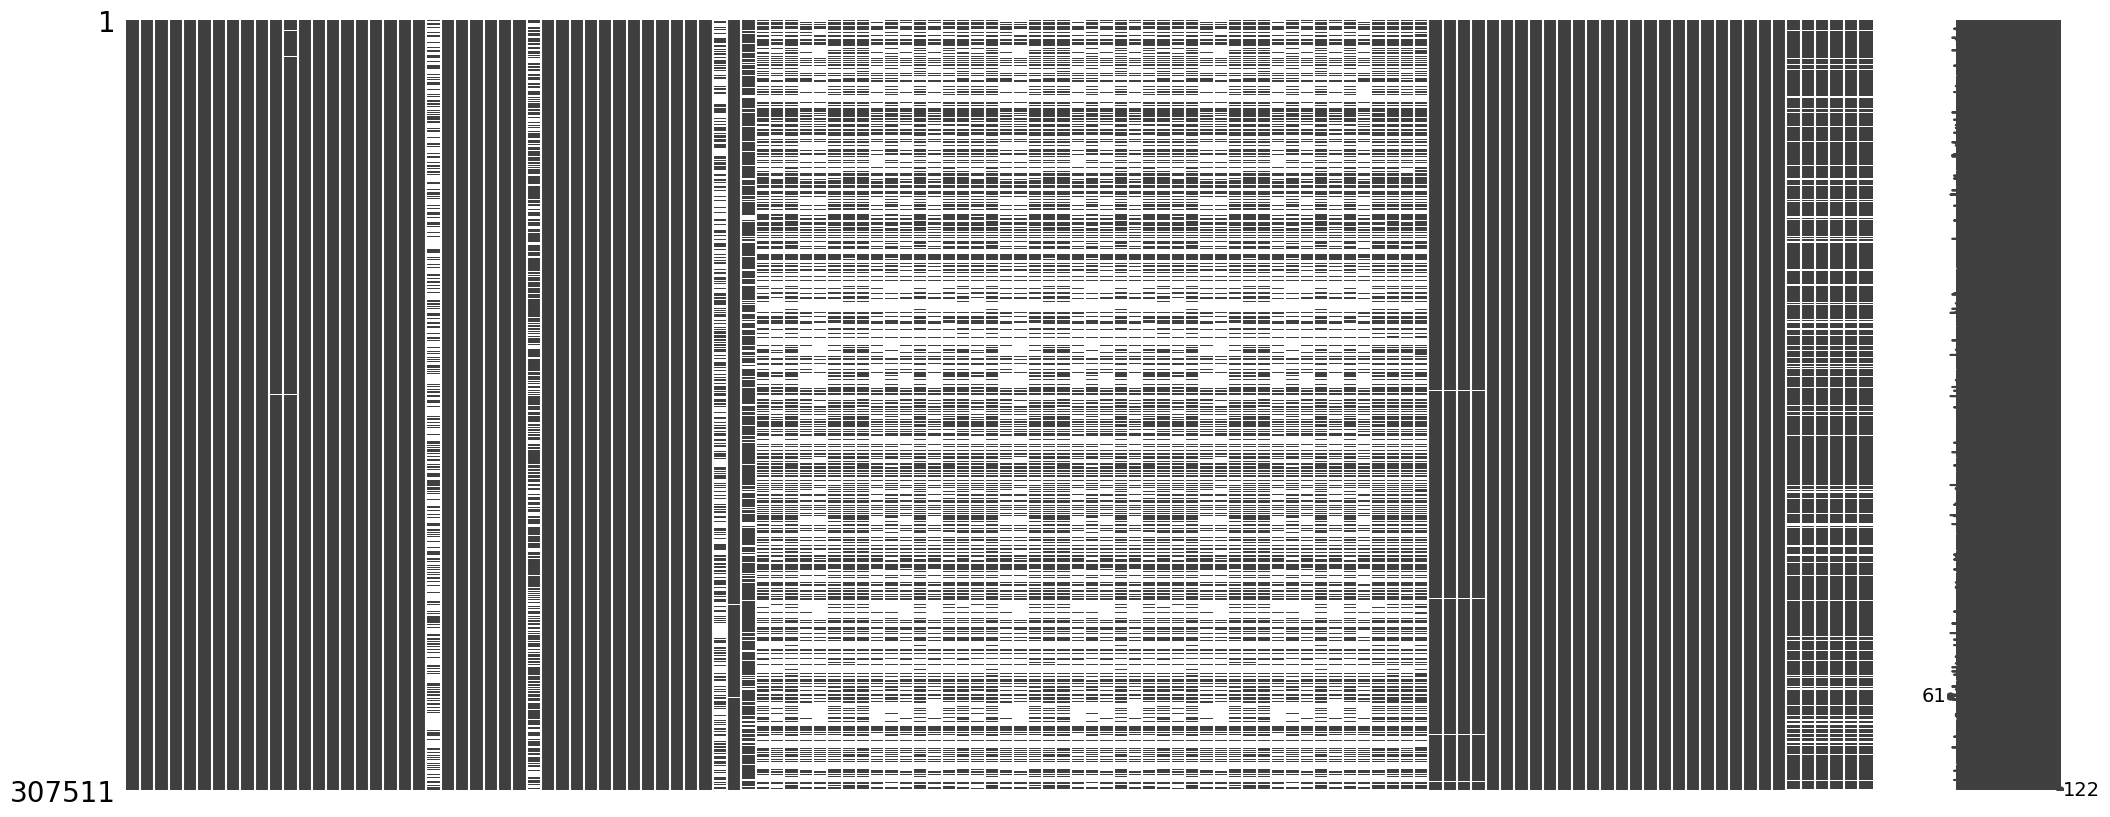

In [24]:
msno.matrix(df_train)

In [25]:
df_train['TARGET'].value_counts() / len(df_train) * 100

TARGET
0    91.927118
1     8.072882
Name: count, dtype: float64

In [26]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    n_miss_cols = ratio[ratio > 10.0].index
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')
    if na_name:
        return na_cols, n_miss_cols

In [27]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                          n_miss  ratio
COMMONAREA_AVG            214865  69.87
COMMONAREA_MEDI           214865  69.87
COMMONAREA_MODE           214865  69.87
NONLIVINGAPARTMENTS_AVG   213514  69.43
NONLIVINGAPARTMENTS_MODE  213514  69.43
...                          ...    ...
EXT_SOURCE_2                 660   0.21
AMT_GOODS_PRICE              278   0.09
AMT_ANNUITY                   12   0.00
CNT_FAM_MEMBERS                2   0.00
DAYS_LAST_PHONE_CHANGE         1   0.00

[67 rows x 2 columns]


In [28]:
n_miss_cols

Index(['COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE',
       'FLOORSMIN_AVG', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI',
       'YEARS_BUILD_MODE', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_AVG',
       'LANDAREA_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE',
       'BASEMENTAREA_MEDI', 'EXT_SOURCE_1', 'NONLIVINGAREA_MEDI',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'APARTMENTS_AVG',
       'ENTRANCES_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'LIVINGAREA_MODE',
       'LIVINGAREA_MEDI', 'LIVINGAREA_AVG', 'HOUSETYPE_MODE', 'FLOORSMAX_MODE',
       'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'YEARS_BEGINEXPLUATATION_AVG'

#### Drop Missing Value Bigger than Average

In [29]:
df_train.drop(n_miss_cols, axis=1, inplace=True)

In [30]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                          n_miss  ratio
NAME_TYPE_SUITE             1292   0.42
OBS_30_CNT_SOCIAL_CIRCLE    1021   0.33
DEF_60_CNT_SOCIAL_CIRCLE    1021   0.33
DEF_30_CNT_SOCIAL_CIRCLE    1021   0.33
OBS_60_CNT_SOCIAL_CIRCLE    1021   0.33
EXT_SOURCE_2                 660   0.21
AMT_GOODS_PRICE              278   0.09
AMT_ANNUITY                   12   0.00
CNT_FAM_MEMBERS                2   0.00
DAYS_LAST_PHONE_CHANGE         1   0.00


### Imputer Another Missing Value

In [31]:
from sklearn.impute import KNNImputer

In [32]:
imputer = KNNImputer(n_neighbors=5)

In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 65
cat_cols: 51
num_cols: 12
cat_but_car: 1
num_but_cat: 41


In [34]:
na_num_cols = df_train[na_cols].select_dtypes(include='float').columns

In [35]:
df_train[na_num_cols] = pd.DataFrame(imputer.fit_transform(df_train[na_num_cols]), columns=df_train[na_num_cols].columns)

In [36]:
na_cols, n_miss_cols = missing_values_table(df_train, True)

                 n_miss  ratio
NAME_TYPE_SUITE    1292   0.42


### Imputer Categorical Columns

In [37]:
name_type_col_mode = df_train[na_cols].value_counts().index[0][0]
name_type_col_mode

'Unaccompanied'

In [38]:
df_train.loc[df_train[na_cols].isnull().NAME_TYPE_SUITE.values, na_cols] = name_type_col_mode

In [39]:
df_train[na_cols].isnull().sum()

NAME_TYPE_SUITE    0
dtype: int64

In [40]:
df_train['TARGET'].values

array([1, 0, 0, ..., 0, 1, 0])

# Scaling Data

In [41]:
df_train[num_cols].dtypes

AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                    float64
DAYS_EMPLOYED                 float64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH               float64
HOUR_APPR_PROCESS_START         int64
EXT_SOURCE_2                  float64
DAYS_LAST_PHONE_CHANGE        float64
dtype: object

In [42]:
robust_scaler = RobustScaler()

In [43]:
df_train[num_cols] = robust_scaler.fit_transform(df_train[num_cols])

In [44]:
df_train[num_cols].head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE
0,0.615,-0.198521,-0.011205,-0.224490,-0.002626,0.865181,0.233104,0.156504,0.439705,-0.50,-1.118246,-0.290895
1,1.365,1.448012,0.597361,1.540816,-0.820550,-0.139634,0.010117,0.606637,1.148895,-0.25,0.208678,-0.054784
2,-0.885,-0.702740,-1.004482,-0.714286,-0.472638,-0.453432,0.399838,0.044611,0.280341,-0.75,-0.036300,-0.044753
3,-0.135,-0.372874,0.264691,-0.346939,-0.580533,-0.447792,-0.738972,-0.974312,0.316789,1.25,0.312808,0.108025
4,-0.285,-0.000986,-0.168078,0.142857,0.525969,-0.575320,-0.738567,0.035287,-0.079100,-0.25,-0.897436,-0.269290


## Encoding

### Label Encoding
Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created.

In [45]:
def label_encoder(dataframe, binary_col):
    labelEncoder = LabelEncoder()
    dataframe[binary_col] = labelEncoder.fit_transform(dataframe[binary_col])
    return dataframe

In [46]:
binary_cols = [col for col in df_train.columns if df_train[col].dtypes not in ['int64', 'float64'] and df_train[col].nunique() == 2]

In [47]:
for col in binary_cols:
    label_encoder(df_train, col)

In [48]:
df_train[cat_cols].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,0,M,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,WEDNESDAY,...,0,0,0,0,0,0,0,0,0,0
1,0,F,0,0,Family,State servant,Higher education,Married,House / apartment,MONDAY,...,0,0,0,0,0,0,0,0,0,0
2,1,M,1,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,MONDAY,...,0,0,0,0,0,0,0,0,0,0
3,0,F,0,1,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,WEDNESDAY,...,0,0,0,0,0,0,0,0,0,0
4,0,M,0,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,THURSDAY,...,0,0,0,0,0,0,0,0,0,0


In [49]:
for col in cat_cols:
    print(df_train[col].value_counts())
    print("----------------------------")

NAME_CONTRACT_TYPE
0    278232
1     29279
Name: count, dtype: int64
----------------------------
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64
----------------------------
FLAG_OWN_CAR
0    202924
1    104587
Name: count, dtype: int64
----------------------------
FLAG_OWN_REALTY
1    213312
0     94199
Name: count, dtype: int64
----------------------------
NAME_TYPE_SUITE
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64
----------------------------
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64
----------------------------
NAME_EDUCATION_TYPE
Secondary / s

### One Hot Encoder
One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.

In [50]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [51]:
one_hot_cols = [col for col in cat_cols if 10 >= df_train[col].nunique() > 2]

In [52]:
one_hot_cols

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

In [53]:
df_train = one_hot_encoder(df_train, one_hot_cols, True)

In [54]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CNT_FAM_MEMBERS_2.0,CNT_FAM_MEMBERS_2.4,CNT_FAM_MEMBERS_2.8,CNT_FAM_MEMBERS_3.0,CNT_FAM_MEMBERS_4.0,CNT_FAM_MEMBERS_4.5,REGION_RATING_CLIENT_2,REGION_RATING_CLIENT_3,REGION_RATING_CLIENT_W_CITY_2,REGION_RATING_CLIENT_W_CITY_3
0,100002,1,0,0,1,0.615,-0.198521,-0.011205,-0.224490,-0.002626,...,False,False,False,False,False,False,True,False,True,False
1,100003,0,0,0,0,1.365,1.448012,0.597361,1.540816,-0.820550,...,True,False,False,False,False,False,False,False,False,False
2,100004,0,1,1,1,-0.885,-0.702740,-1.004482,-0.714286,-0.472638,...,False,False,False,False,False,False,True,False,True,False
3,100006,0,0,0,1,-0.135,-0.372874,0.264691,-0.346939,-0.580533,...,True,False,False,False,False,False,True,False,True,False
4,100007,0,0,0,1,-0.285,-0.000986,-0.168078,0.142857,0.525969,...,False,False,False,False,False,False,True,False,True,False


The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

## Data Analysis

In [55]:
df_train["TARGET"].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

In [56]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 102
cat_cols: 85
num_cols: 15
cat_but_car: 1
num_but_cat: 85


In [57]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("****************************************************")

    if plot:
        sns.countplot(x=col_name, data=dataframe)
        plt.show(block=True)


In [58]:
for col in cat_cols:
    cat_summary(df_train, col)

        TARGET      Ratio
TARGET                   
0       282686  91.927118
1        24825   8.072882
****************************************************
                    NAME_CONTRACT_TYPE      Ratio
NAME_CONTRACT_TYPE                               
0                               278232  90.478715
1                                29279   9.521285
****************************************************
              FLAG_OWN_CAR      Ratio
FLAG_OWN_CAR                         
0                   202924  65.989184
1                   104587  34.010816
****************************************************
                 FLAG_OWN_REALTY      Ratio
FLAG_OWN_REALTY                            
1                         213312  69.367275
0                          94199  30.632725
****************************************************
            FLAG_MOBIL      Ratio
FLAG_MOBIL                       
1               307510  99.999675
0                    1   0.000325
********************

In [59]:
cat_cols = [col for col in cat_cols if df_train[col].nunique() > 2 and df_train[col].dtypes not in ['float', 'int']]
cat_cols

[]

In [60]:
def plot_cat_cols(df_train, cat_cols):
    width_cols = 3
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 14))
    plt.subplots_adjust(right=2)
    plt.subplots_adjust(top=2)
    for i, col in enumerate(cat_cols, start=1):
        plt.subplot(math.ceil(len(cat_cols) / width_cols), width_cols, i)
        sns.countplot(x=col, data=df_train, saturation=1,);
        plt.xlabel(col, fontsize=18)
        plt.ylabel("Count", fontsize=16)
        plt.xticks(fontsize=16, rotation=45, ha='right')
        plt.yticks(fontsize=14)

    plt.show();

In [61]:
object_cols = df_train.select_dtypes(include='object')
df_train.drop(object_cols, axis=1, inplace=True)

## Rename all columns and Determine x, y 

In [62]:
from sklearn.model_selection import train_test_split
import re

In [63]:
df_train = df_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'CNT_FAM_MEMBERS_20', 'CNT_FAM_MEMBERS_24', 'CNT_FAM_MEMBERS_28',
       'CNT_FAM_MEMBERS_30', 'CNT_FAM_MEMBERS_40', 'CNT_FAM_MEMBERS_45',
       'REGION_RATING_CLIENT_2', 'REGION_RATING_CLIENT_3',
       'REGION_RATING_CLIENT_W_CITY_2', 'REGION_RATING_CLIENT_W_CITY_3'],
      dtype='object', length=101)

In [64]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_train)

Observations: 307511
Variables: 101
cat_cols: 85
num_cols: 15
cat_but_car: 0
num_but_cat: 85


In [65]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']

## Balanced Target feature by using SMOTE algorithm

<Axes: xlabel='TARGET'>

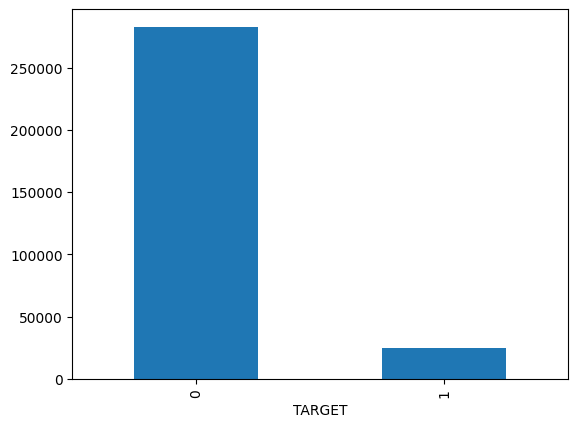

In [66]:
y.value_counts().plot(kind='bar')

In [67]:
car_cols = [col for col in X.columns if X[col].dtypes not in ['float', 'int', 'bool']]
X.drop(car_cols, axis=1, inplace=True)

In [68]:
from imblearn.over_sampling import SMOTE

In [69]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

<Axes: xlabel='TARGET'>

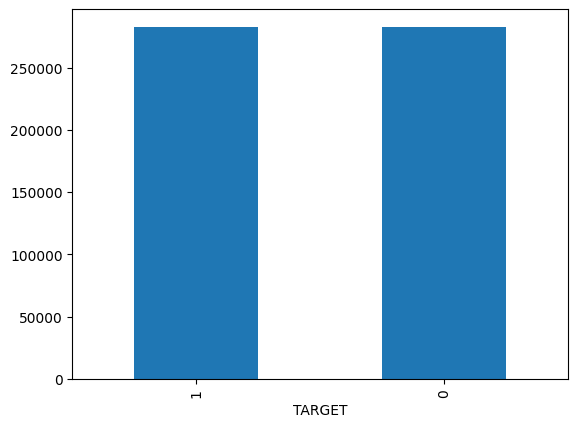

In [70]:
y.value_counts().plot(kind='bar')

## Split Data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)

In [72]:
len(X_train), len(X_test), len(y_train), len(y_test)

(378799, 186573, 378799, 186573)

## Base Model

### Step 1: Use base learner hμ(x) to obtain the feature importance values and rank them in descending order. The rules for calculating feature importance for the different base learners are as follows:

### Determine Heterogeneous Ensemble Learning Methods and plot importance for each method

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import re

In [74]:
df_train.columns[:10]

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE'],
      dtype='object')

In [75]:
def plot_importance(importance, features, num=10, save=False):

    #features_length = round(len(features.columns) * 0.7)
    feature_imp = pd.DataFrame({'Value': importance, 'Feature': features.columns})
    plt.figure(figsize=(10, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
    return feature_imp['Feature'].head(num)

In [76]:
classifiers = [('DT', DecisionTreeClassifier()),
               ('RF', RandomForestClassifier()),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')),
               ('LightGBM', LGBMClassifier(verbose=-1, device='gpu'))]

In [77]:
models = {}
for name, classifier in classifiers:
    print(name)
    model = classifier.fit(X_train, y_train)
    models[name] = model

DT
RF
XGBoost
LightGBM


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


In [78]:
models.items()

dict_items([('DT', DecisionTreeClassifier()), ('RF', RandomForestClassifier()), ('XGBoost', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)), ('LightGBM', LGBMClassifier(device='gpu', verbose=-1))])

### Step 2: Delete the last ranked feature according to the feature importance ranking and use the other features to train the base learner hμ(x);

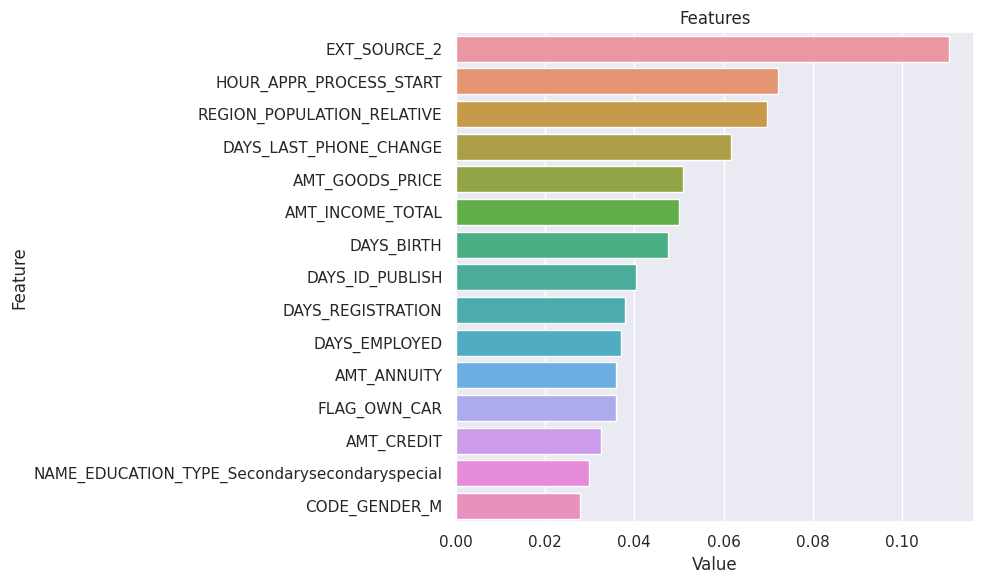

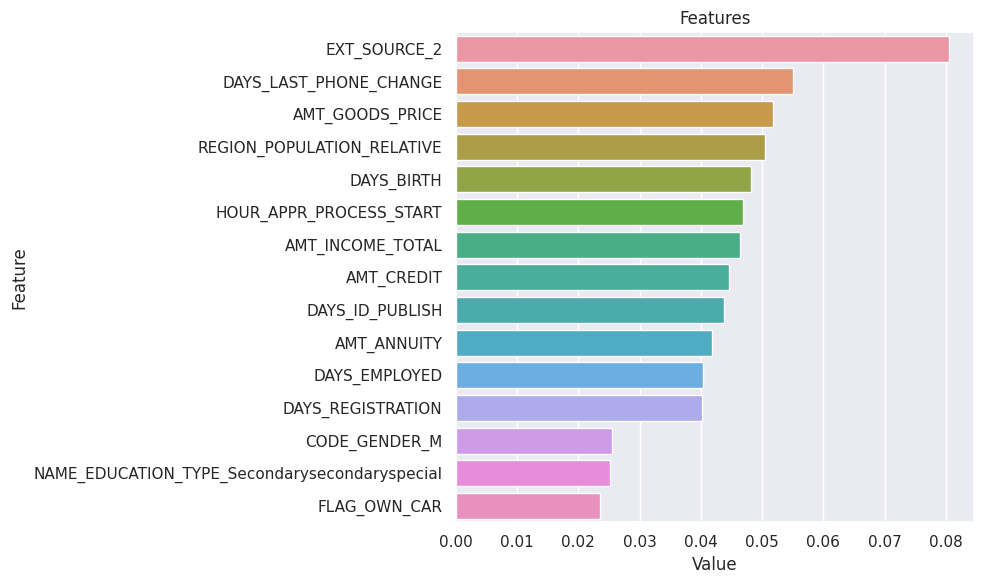

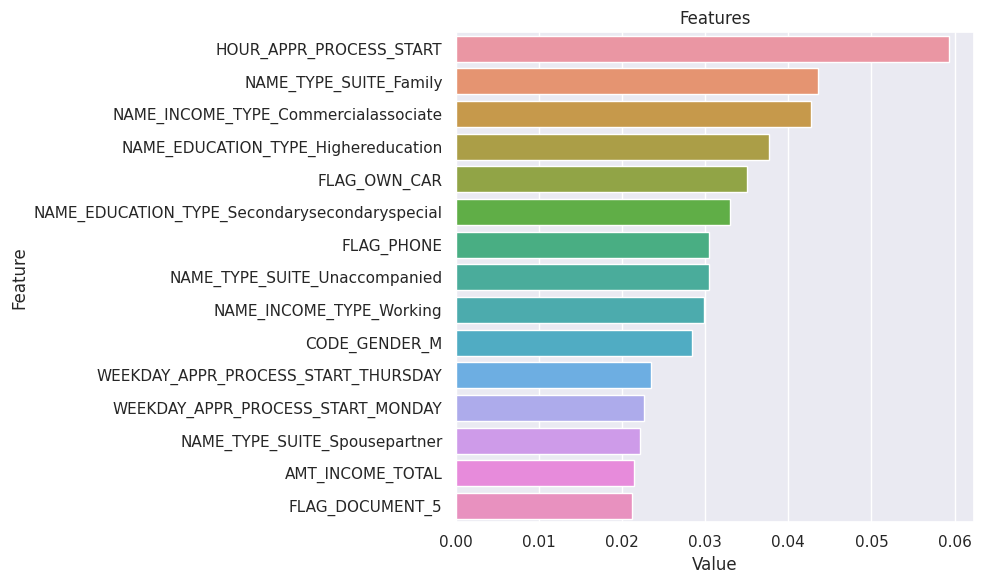

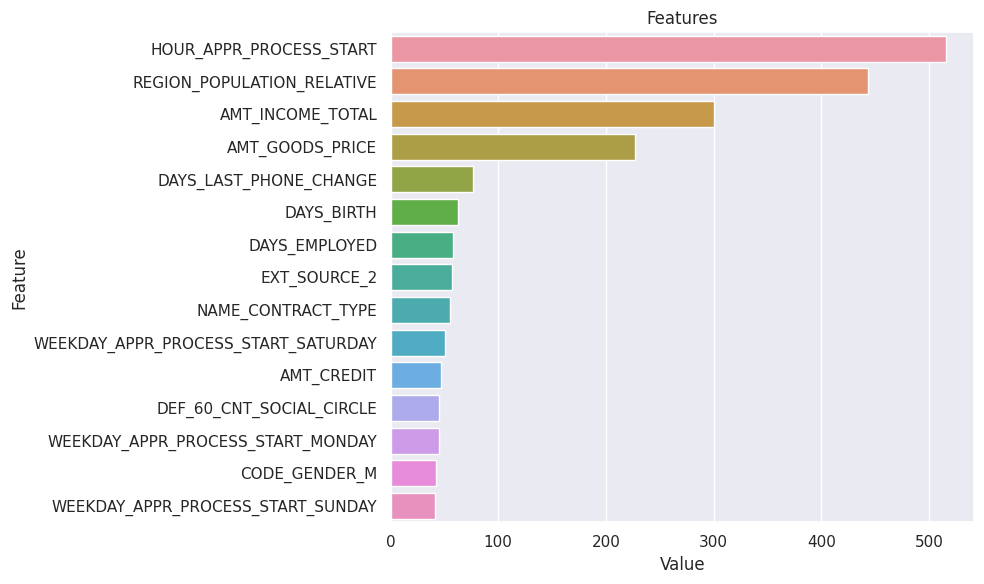

In [79]:
importance_dict = {}
for name, model in models.items():
    features_cols = plot_importance(model.feature_importances_, X_train, 15)
    importance_dict[name] = features_cols

In [80]:
importance_dict

{'DT': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 4                     AMT_CREDIT
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS_BIRTH
 9                  DAYS_EMPLOYED
 10             DAYS_REGISTRATION
 11               DAYS_ID_PUBLISH
 12                    FLAG_MOBIL
 13                FLAG_EMP_PHONE
 14               FLAG_WORK_PHONE
 Name: Feature, dtype: object,
 'RF': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 4                     AMT_CREDIT
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS_BIRTH
 9                  DAYS_EMPLOYED
 10             DAYS_REGISTRATION
 11               DAYS_ID_PUBLISH
 12                    FLAG_MOBIL
 13  

In [81]:
X_train[importance_dict['RF']].head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE
386404,0,0,1,0.041435,0.241542,-0.243745,0.405149,-0.159853,-0.662108,1.873938,-1.286484,0.164729,1,0,0
483113,0,1,0,0.184981,-0.549803,-0.346893,-0.542839,-0.205171,0.949082,0.244198,-0.142123,1.010458,1,1,1
376452,0,0,1,-0.881490,-0.783340,-0.896549,-0.836950,-0.423605,0.615320,-0.021258,-0.046892,0.941329,1,1,0
135407,0,1,1,0.865000,0.930585,1.621016,1.051020,0.734898,-0.494979,0.312829,-0.732974,0.388523,1,1,0
432316,0,0,0,0.437326,-0.168986,-0.025924,-0.062343,-0.007705,0.578337,-0.213458,0.244535,-0.249293,1,1,0


In [82]:
models = {}
for name, classifier in classifiers:
    print(name)
    X_train_model = X_train[importance_dict[name]]
    model = classifier.fit(X_train_model, y_train)
    models[name] = model

DT
RF
XGBoost
LightGBM


# Save Models

In [83]:
import pickle

In [84]:
for name, model in models.items():
    pickle.dump(model, open(f"{name}_pickle", 'wb'))
    print(f"Save {name} model successfully")

Save DT model successfully
Save RF model successfully
Save XGBoost model successfully
Save LightGBM model successfully


In [85]:
rf_model = pickle.load(open(f"RF_pickle", 'rb'))
rf_model

RandomForestClassifier()

## Test Score

In [86]:
for name, model in models.items():
    X_test_model = X_test[importance_dict[name]]
    score = model.score(X_test_model, y_test)
    print(f"{name} model score is {score}")

DT model score is 0.8499890123436938
RF model score is 0.8990636372894256
XGBoost model score is 0.9095742685168808
LightGBM model score is 0.9257127237060024


In [87]:
importance_dict

{'DT': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 4                     AMT_CREDIT
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS_BIRTH
 9                  DAYS_EMPLOYED
 10             DAYS_REGISTRATION
 11               DAYS_ID_PUBLISH
 12                    FLAG_MOBIL
 13                FLAG_EMP_PHONE
 14               FLAG_WORK_PHONE
 Name: Feature, dtype: object,
 'RF': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 4                     AMT_CREDIT
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS_BIRTH
 9                  DAYS_EMPLOYED
 10             DAYS_REGISTRATION
 11               DAYS_ID_PUBLISH
 12                    FLAG_MOBIL
 13  

## Evulate Models
### Step 3: Evaluate the base learner hμ(x) using AUC indicators;

In [88]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

### Step 4: If the AUC value is reduced by more than 0.001, the last feature is retained; otherwise, the last feature is deleted;

In [89]:
X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
#X = X[importance_dict['RF']]
y = df_train['TARGET']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)

In [91]:
X_test.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_D

In [92]:
X_train.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
       'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
       'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
       'FLAG_DOCUMENT_12', 'FLAG_D

In [93]:
model_rf = models['RF']
model_rf.feature_names_in_

array(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE'], dtype=object)

In [94]:
def train_prediction_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    #model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    return model, y_score, X_test

In [95]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
        
    for index in range(len(X_test.columns)-1, 1, -1):  
        y_score_before = model.predict_proba(X_test)[:, 1]
        roc_score_before = roc_auc_score(y_test, y_score_before)
        print("Roc score Before:", roc_score_before)
        
        last_col = X.columns[index]
        X = X.drop(last_col, axis=1)
        print("X shape: ", X.shape)
        
        model_rf, y_score_after, X_test = train_prediction_model(model, X, y)
        roc_score_after = roc_auc_score(y_test, y_score_after)
        print("Roc score after:", roc_score_after)
        
        if roc_score_before - roc_score_after < 0.001:
            print(f"the feature is {last_col}")
            importance_dict[name].pop(index)
        print("-------------------------------------------")
print(importance_dict['RF'])

The Model is DT
Roc score Before: 0.8069453474311888
X shape:  (307511, 14)
Roc score after: 0.5159970556703372
-------------------------------------------
Roc score Before: 0.5159970556703372
X shape:  (307511, 13)
Roc score after: 0.5143228270174754
-------------------------------------------
Roc score Before: 0.5143228270174754
X shape:  (307511, 12)
Roc score after: 0.5169983444725254
the feature is FLAG_MOBIL
-------------------------------------------
Roc score Before: 0.5169983444725254
X shape:  (307511, 11)
Roc score after: 0.5170741087248458
the feature is DAYS_ID_PUBLISH
-------------------------------------------
Roc score Before: 0.5170741087248458
X shape:  (307511, 10)
Roc score after: 0.5159946955441106
-------------------------------------------
Roc score Before: 0.5159946955441106
X shape:  (307511, 9)
Roc score after: 0.5176820007139185
the feature is DAYS_EMPLOYED
-------------------------------------------
Roc score Before: 0.5176820007139185
X shape:  (307511, 8)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Roc score after: 0.5410825216428695
-------------------------------------------
Roc score Before: 0.5410825216428695
X shape:  (307511, 2)
Roc score after: 0.5341484478179636
-------------------------------------------
0             NAME_CONTRACT_TYPE
1                   FLAG_OWN_CAR
2                FLAG_OWN_REALTY
3               AMT_INCOME_TOTAL
5                    AMT_ANNUITY
6                AMT_GOODS_PRICE
7     REGION_POPULATION_RELATIVE
8                     DAYS_BIRTH
9                  DAYS_EMPLOYED
10             DAYS_REGISTRATION
11               DAYS_ID_PUBLISH
14               FLAG_WORK_PHONE
Name: Feature, dtype: object


In [100]:
importance_dict

{'DT': 0     NAME_CONTRACT_TYPE
 1           FLAG_OWN_CAR
 2        FLAG_OWN_REALTY
 3       AMT_INCOME_TOTAL
 6        AMT_GOODS_PRICE
 10     DAYS_REGISTRATION
 13        FLAG_EMP_PHONE
 14       FLAG_WORK_PHONE
 Name: Feature, dtype: object,
 'RF': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS_BIRTH
 9                  DAYS_EMPLOYED
 10             DAYS_REGISTRATION
 11               DAYS_ID_PUBLISH
 14               FLAG_WORK_PHONE
 Name: Feature, dtype: object,
 'XGBoost': 0             NAME_CONTRACT_TYPE
 1                   FLAG_OWN_CAR
 2                FLAG_OWN_REALTY
 3               AMT_INCOME_TOTAL
 4                     AMT_CREDIT
 5                    AMT_ANNUITY
 6                AMT_GOODS_PRICE
 7     REGION_POPULATION_RELATIVE
 8                     DAYS

In [96]:
len(X_test.columns), X_test.shape

(2, (101479, 2))

In [97]:
X_test.drop(X_test.columns[len(X_test.columns)-1], axis=1).shape

(101479, 1)

In [99]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    model.fit(X_train, y_train)  
    score = model.score(X_test, y_test)
    print(f"{name} model score is {score}")

The Model is DT
DT model score is 0.84790941968289
The Model is RF
RF model score is 0.9195104405837661
The Model is XGBoost
XGBoost model score is 0.9194118980281635
The Model is LightGBM
LightGBM model score is 0.9195400033504469


The Model is DT


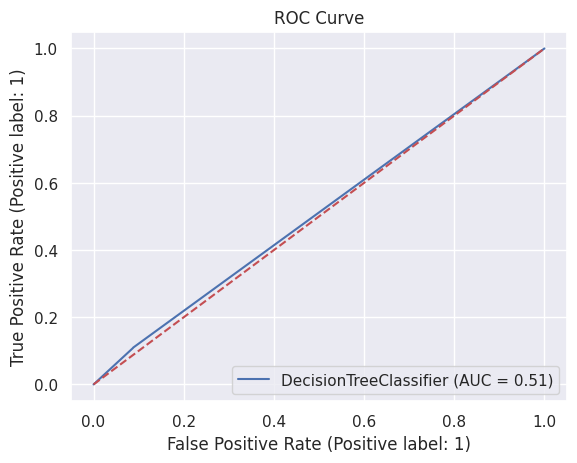

The Model is RF


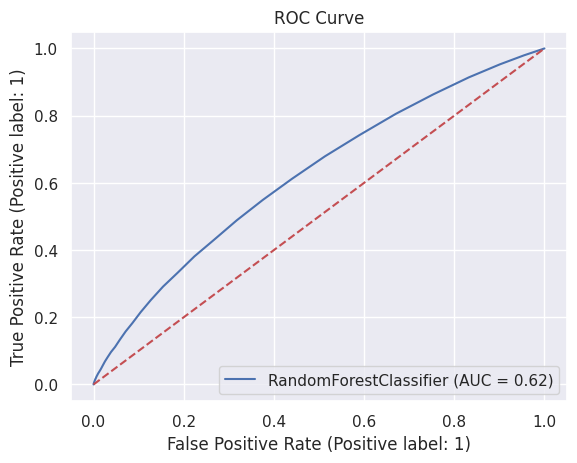

The Model is XGBoost


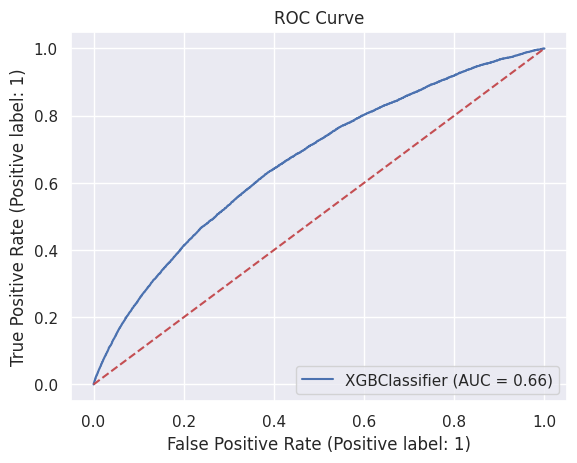

The Model is LightGBM


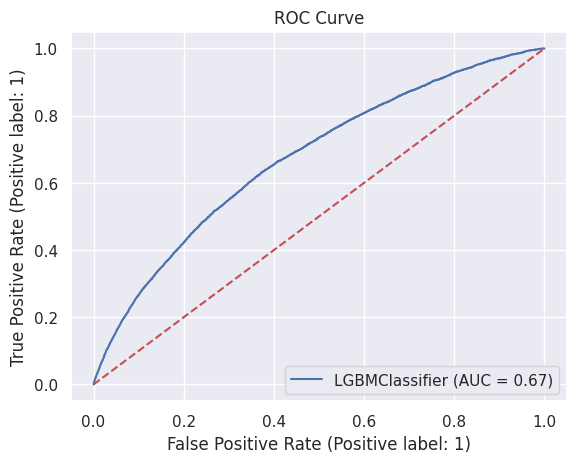

In [101]:
for name, model in models.items():
    X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
    print(f"The Model is {name}")
    X = X[importance_dict[name]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2024)
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()

## Save Models

In [102]:
import pickle
for name, model in models.items():
    pickle.dump(model, open(f"{name}_pickle", 'wb'))
    print(f"Save {name} model successfully")

Save DT model successfully
Save RF model successfully
Save XGBoost model successfully
Save LightGBM model successfully


## Apply Models for test data

In [103]:
path = '/kaggle/input/application-datasets/application_test.csv'
df_test = pd.read_csv(path)
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### PipeLine

In [104]:
from sklearn.pipeline import Pipeline